In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import torch.utils.data as data_utils
import pandas as pd
import os
from multiprocessing import cpu_count, Pool
import sys
import gc
from tqdm import tqdm
import pickle as pkl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
sys.path.append('../')
from wiki.utils import clock
from wiki import newphet, val, rnn
%matplotlib inline


In [11]:
torch.manual_seed(1)
torch.cuda.set_device(0)

In [12]:
batch_size = 256

In [13]:
pred_len = 60

In [3]:
base_dir = '../data/'

In [ ]:
train_df = pd.read_csv(base_dir+'train_1.csv').fillna(0)

In [14]:
len(pages_df)

145063

In [7]:
X = train_df.drop('Page', axis=1).values

In [9]:
X, scaler = rnn.scale_values(X)

In [11]:
trainloader = data_utils.DataLoader(
    data_utils.TensorDataset(
        torch.from_numpy(X[:,:-2*pred_len,:]).float(),
        torch.from_numpy(X[:,-2*pred_len:-pred_len,:]).float()
    ),
    batch_size=batch_size, shuffle=False
)

In [13]:
valloader = data_utils.DataLoader(
    data_utils.TensorDataset(
        torch.from_numpy(X[:,:-pred_len,:]).float(),
        torch.from_numpy(X[:,-pred_len:,:]).float()
    ),
    batch_size=batch_size, shuffle=False
)

In [25]:
testloader = data_utils.DataLoader(
    data_utils.TensorDataset(
        torch.from_numpy(X[:,:,:]).float(),
        torch.zeros(X.shape[0])
    ),
    batch_size=batch_size, shuffle=False
)

In [62]:
def predict_batch(model, sequence_batch, pred_len):
    output = []
    h_state = model.init_hidden(sequence_batch.size()[0])
    x=Variable(sequence_batch, volatile=True).cuda()
    encoder_out, h_state = model(x, h_state)

    input_variable = encoder_out[:,-1:,:]
    output.append(input_variable)
    for i in range(pred_len-1):
        encoder_out, h_state = model(input_variable, h_state)
        input_variable = encoder_out
        output.append(encoder_out)
    
    return torch.cat(output, dim=1)

In [75]:
def validate(model, valloader):
    loss_func = nn.L1Loss()
    loss = 0
    steps = 0
    for sequences, targets in valloader:
        pred_len = targets.size()[1]
        targets = Variable(targets, volatile=True).cuda()
        output = predict_batch(model, sequences, pred_len)
        loss += loss_func(output, targets)
        steps+=1
    average_loss = loss.data[0]/(steps*pred_len)
    print('VALIDATION LOSS: %f' % float(average_loss))

False

In [30]:
loss_func = nn.L1Loss()
model = rnn.RNN(loss_func=loss_func)

In [223]:
optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
with clock():
    model.fit(trainloader, valloader, optimizer=optimizer, num_epochs=10)

Notes on above:
- rewriting the loss function to the log likelihood maximizer for negative binomial distribution is doable
    - upon thinking further it seems that a poisson distribution more accurately should model pageviews (see [this paper](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=18EDC4D891D952D5706850A0B33D0561?doi=10.1.1.77.3333&rep=rep1&type=pdf) for discussion to the contrary though) and pytorch has a loss function for negative likelihood w/ poisson distribution already
    - _however_ we're scaling the inputs so we lose the whole integer thing anyway, in which case a logistic distribution might be more appropriate? hooker will know more about this. pytorch will have some log likelihood loss function 
- adding meta features again doable by concatenating them onto the `Variable`s
- to implement an embedding, would presumably have to add the embedding variables to to optimizer's initialiser, then do a lookup to concatentate them before giving them to the RNN. 
  - though it seems somewhat likely that pytorch has something built to deal with embeddings already too

In [98]:
with clock():
    rnn = train(trainloader, valloader, batch_size, num_epochs=2)

RNN (
  (rnn): GRU(1, 128, num_layers=2, batch_first=True, dropout=0.2)
  (out): Linear (128 -> 1)
)
Val loss, 0.007406ss: 0.408375
Elapsed time 191.53125667572021 seconds


/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Val loss, 0.007387ss: 0.381050
Elapsed time 191.78038430213928 seconds
Elapsed time 383.3669764995575 seconds


In [101]:
with clock():
    rnn = train(trainloader, valloader, batch_size, num_epochs=5, model=rnn)

RNN (
  (rnn): GRU(1, 128, num_layers=2, batch_first=True, dropout=0.2)
  (out): Linear (128 -> 1)
)
Val loss, 0.007172ss: 0.374187
Elapsed time 191.07567524909973 seconds


/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Val loss, 0.007369ss: 0.362905
Elapsed time 191.30143880844116 seconds
Val loss, 0.007332ss: 0.360902
Elapsed time 191.06158018112183 seconds
Val loss, 0.007096ss: 0.360590
Elapsed time 190.1902778148651 seconds
Val loss, 0.006332ss: 0.344502
Elapsed time 192.04927110671997 seconds
Elapsed time 955.7056794166565 seconds


In [103]:
with clock():
    new = train(trainloader, valloader, batch_size, num_epochs=5, model=rnn)

RNN (
  (rnn): GRU(1, 128, num_layers=2, batch_first=True, dropout=0.2)
  (out): Linear (128 -> 1)
)
Val loss, 0.007078ss: 0.334989
Elapsed time 191.93351101875305 seconds


/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Val loss, 0.006261ss: 0.329177
Elapsed time 191.92325901985168 seconds
Val loss, 0.006101ss: 0.328898
Elapsed time 191.00333786010742 seconds
Val loss, 0.006941ss: 0.324145
Elapsed time 191.9596230983734 seconds
Val loss, 0.006000ss: 0.332623
Elapsed time 191.72847604751587 seconds
Elapsed time 958.5766069889069 seconds


In [104]:
def predict(model, dataloader):
    all_output = []
    all_targets = []
    all_sequences = []
    for sequences, t in dataloader:
        pred_len = t.size()[1]
        output = predict_batch(model, sequences, pred_len)
        all_output.append(output)
        all_targets.append(t)
        all_sequences.append(sequences)
    cat = lambda x: torch.cat(x, dim=0)
    return cat(all_output), cat(all_targets), cat(all_sequences)

In [224]:
with clock():
    new = train(trainloader, valloader, batch_size, num_epochs=5, model=new)

RNN (
  (rnn): GRU(1, 128, num_layers=2, batch_first=True, dropout=0.2)
  (out): Linear (128 -> 1)
)
Val loss, 0.006088ss: 0.322105
Elapsed time 211.87474656105042 seconds


/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Val loss, 0.006082ss: 0.321975
Elapsed time 214.00328826904297 seconds
Val loss, 0.005913ss: 0.319356
Elapsed time 212.9439730644226 seconds
Val loss, 0.005939ss: 0.317005
Elapsed time 213.31986689567566 seconds
Val loss, 0.006210ss: 0.317760
Elapsed time 212.5765552520752 seconds
Elapsed time 1064.746686220169 seconds


In [172]:
outputs, targets, sequences = predict(new, testloader)

In [173]:
predictions_end = outputs.cpu().data.numpy().squeeze()

In [174]:
truth_end = targets.cpu().numpy().squeeze()

In [175]:
truth_start = sequences.cpu().numpy().squeeze()

In [176]:
truth = np.concatenate((truth_start, truth_end), axis=1) ; truth.shape

(145063, 550)

In [177]:
truth

array([[-0.127924  , -0.36631092, -0.57064253, ..., -0.09386872,
        -0.127924  , -0.05981344],
       [-0.4238902 , -0.33553511, -0.30608344, ...,  0.57746738,
         0.01788521, -0.15882495],
       [-0.31152704, -0.385636  , -0.31152704, ..., -0.16330917,
        -0.08920022,  0.87421608],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [181]:
truth = scaler.inverse_transform(truth.T).T

In [204]:
predictions = np.concatenate((truth_start, predictions_end), axis=1) ; predictions.shape

(145063, 550)

In [205]:
predictions = scaler.inverse_transform(predictions.T).T

In [206]:
dates = pd.read_csv(base_dir+'train_1.csv').fillna(0).drop('Page', axis=1).transpose().index.values

In [227]:
def create_val_df(row_tuple, dates):
    pred_r, truth_r = row_tuple
    df = pd.DataFrame()
    df['ds'] = pd.to_datetime(dates)
    df['y'] = df['y_org'] = truth_r
    df['yhat'] = pred_r
    df['train'] = [1]*490 + [0]*60
    return df

In [231]:
with clock():
    p = Pool(cpu_count())
    dataframes = p.map(create_val_df, zip(predictions, truth))

Elapsed time 232.67998719215393 seconds


Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/multiprocessing/queues.py",

In [232]:
len(dataframes)

145063

In [298]:
dataframes[0].head()

,ds,y,y_org,yhat,train
0,2015-07-01,18.000000,18.000000,18.000000,1
1,2015-07-02,11.000000,11.000000,11.000000,1
2,2015-07-03,5.000001,5.000001,5.000001,1
3,2015-07-04,13.000000,13.000000,13.000000,1
4,2015-07-05,14.000000,14.000000,14.000000,1


In [263]:
def calc_smape(df):
    return val.smape_df(df[df.train==0], 'y', 'yhat')
p = Pool(cpu_count())
with clock():
    smape_scores = p.map(calc_smape, dataframes)

Elapsed time 377.2461974620819 seconds


Process ForkPoolWorker-19:
Process ForkPoolWorker-18:
Process ForkPoolWorker-21:
Process ForkPoolWorker-20:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/multiprocessing/po

In [297]:
def calc_smape(df):
    df = df[df.train==0]
    df['yhat'] = df['yhat'].clip(lower=0)
    return val.smape_df(df, 'y', 'yhat')
p = Pool(cpu_count())
with clock():
    smape_scores_zero_capped = p.map(calc_smape, dataframes)





/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:

Elapsed time 826.2860150337219 seconds


KeyboardInterrupt: 

In [305]:
dataframes[2].tail()

,ds,y,y_org,yhat,train
545,2016-12-27,4.0,4.0,4.807993,0
546,2016-12-28,6.0,6.0,4.704412,0
547,2016-12-29,3.0,3.0,4.587065,0
548,2016-12-30,4.0,4.0,4.526365,0
549,2016-12-31,17.0,17.0,4.557995,0


In [310]:
import gc
gc.collect()

182

In [311]:
dataframes_dict = {train_df.Page[i]:dataframes[i] for i in range(len(dataframes))}

In [313]:
dataframes = dataframes_dict

In [315]:
page_smape_df = pd.DataFrame()
page_smape_df['page'] = train_df.Page
page_smape_df['smape'] = smape_scores
page_smape_df.head()

,page,smape
0,2NE1_zh.wikipedia.org_all-access_spider,40.095757
1,2PM_zh.wikipedia.org_all-access_spider,39.891933
2,3C_zh.wikipedia.org_all-access_spider,50.212570
3,4minute_zh.wikipedia.org_all-access_spider,34.829330
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,47.325005


In [316]:
import feather

In [322]:
path = '../data/rnn_smape_scores.f'

In [323]:
ls ../data

key_1.csv  rnn.mdl  rnn_smape_scores  sample_submission_1.csv  train_1.csv


In [324]:
page_smape_df.to_feather(path)

In [307]:
train_df.Page[0]

str

In [269]:
smape_scores = pd.Series(smape_scores)

In [ ]:
smape_scores_zero_capped = pd.Series(smape_score_zero_capped)

In [271]:
smape_scores.mean()

44.381664655945031

In [ ]:
smape_scores_zero_capped.mean()

In [246]:
sum(smape_scores)/len(smape_scores)

40.898684335026701

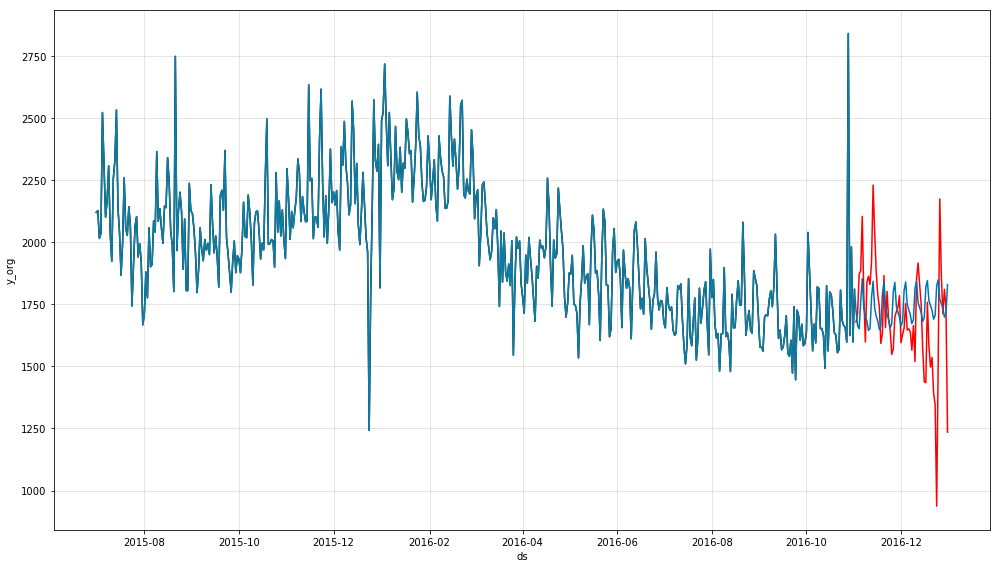

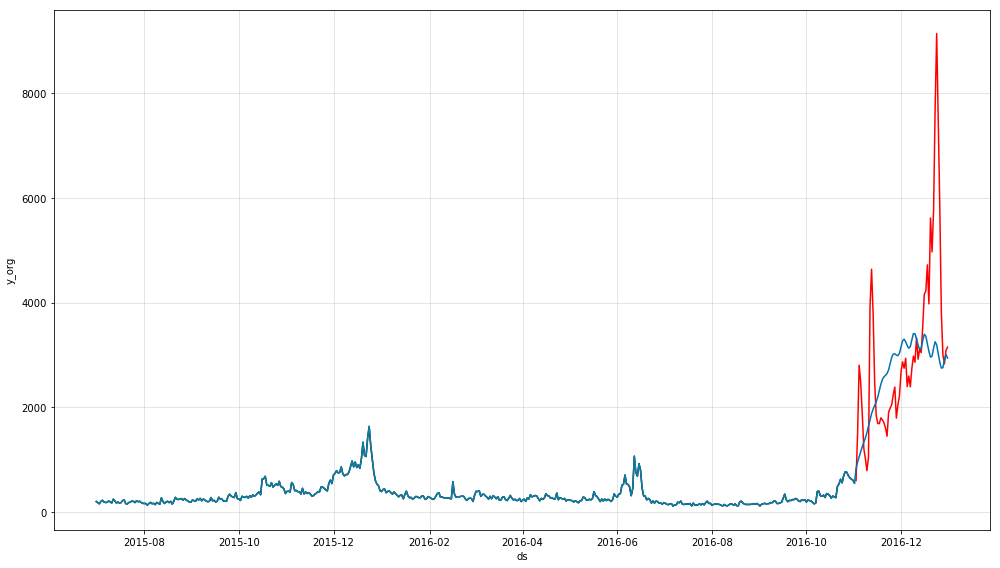

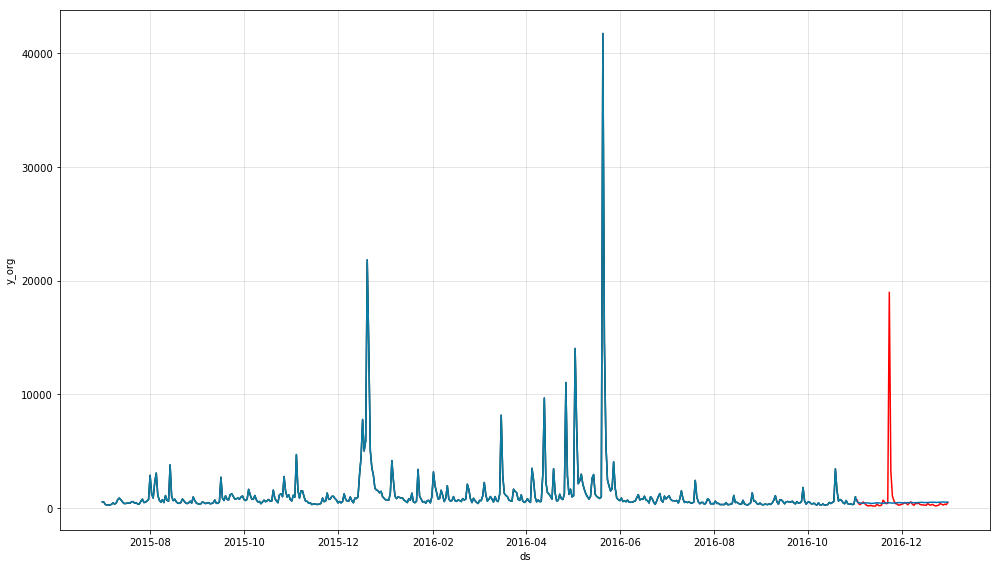

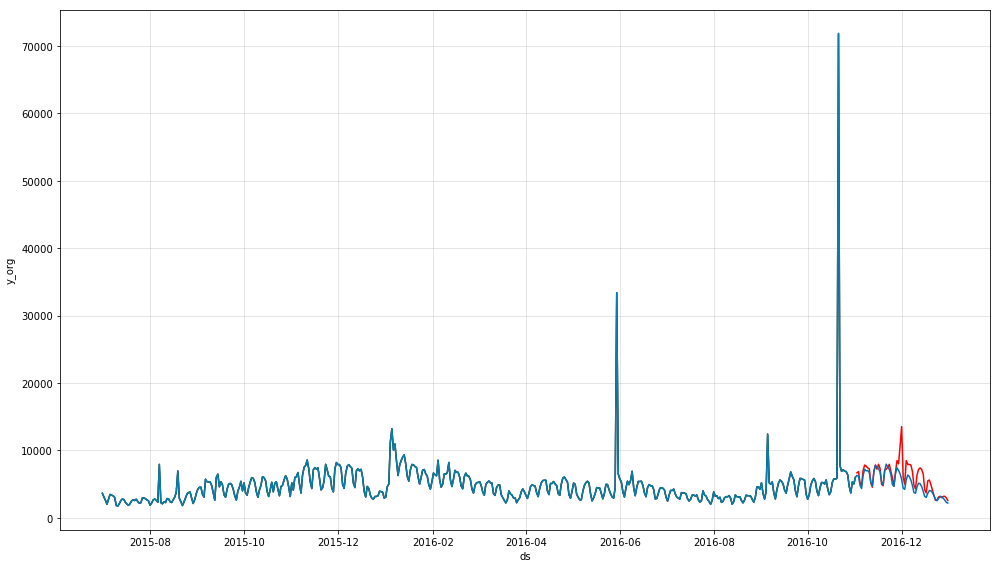

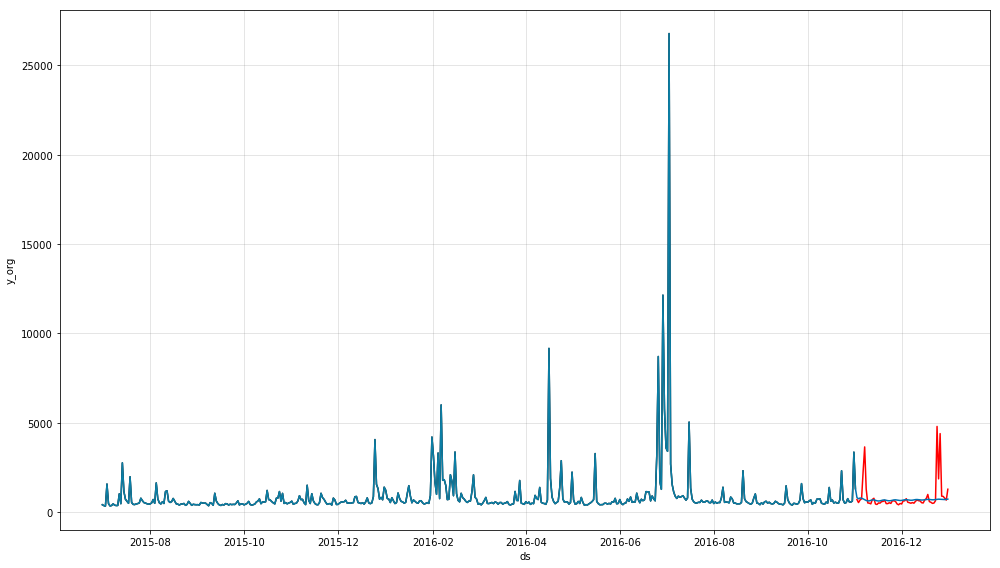

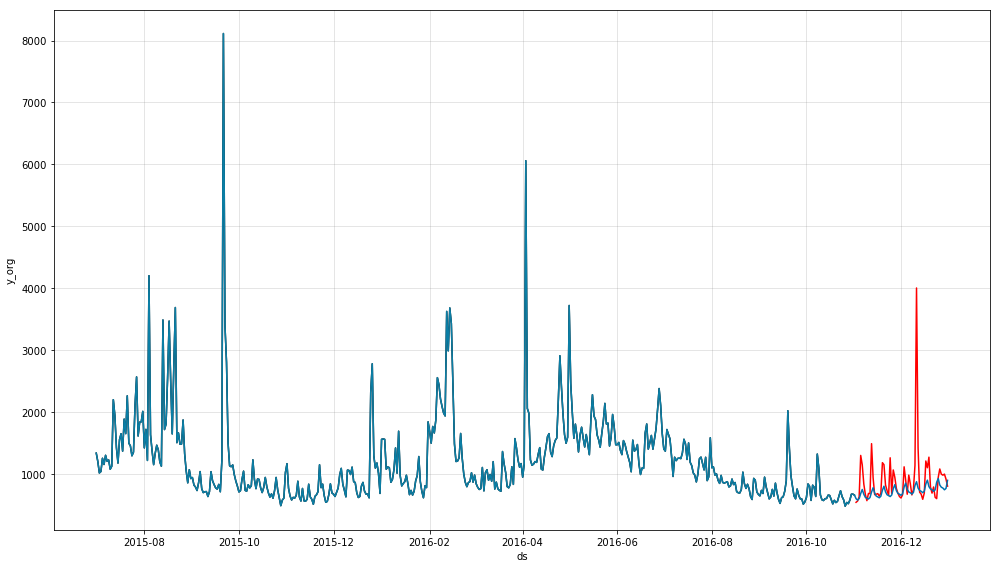

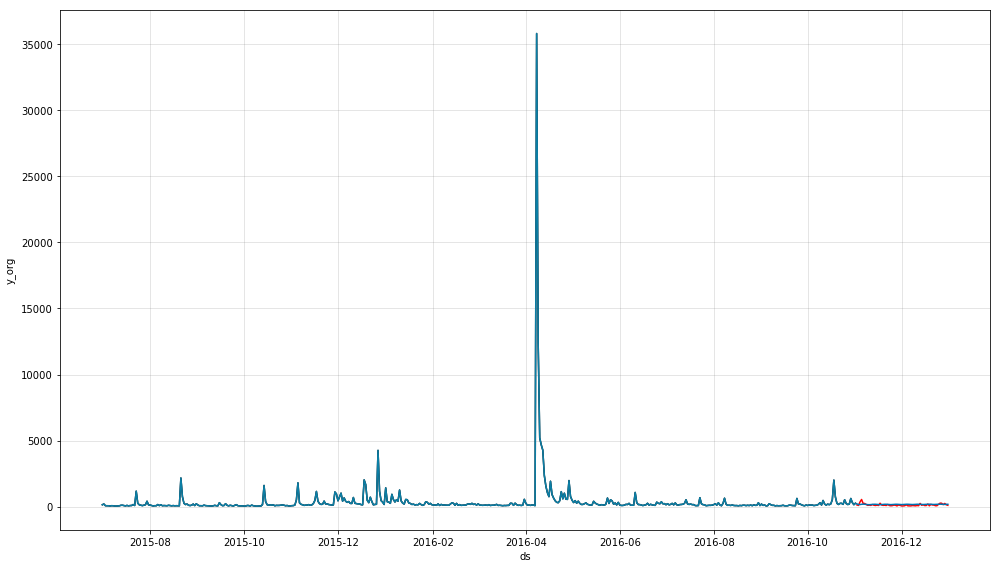

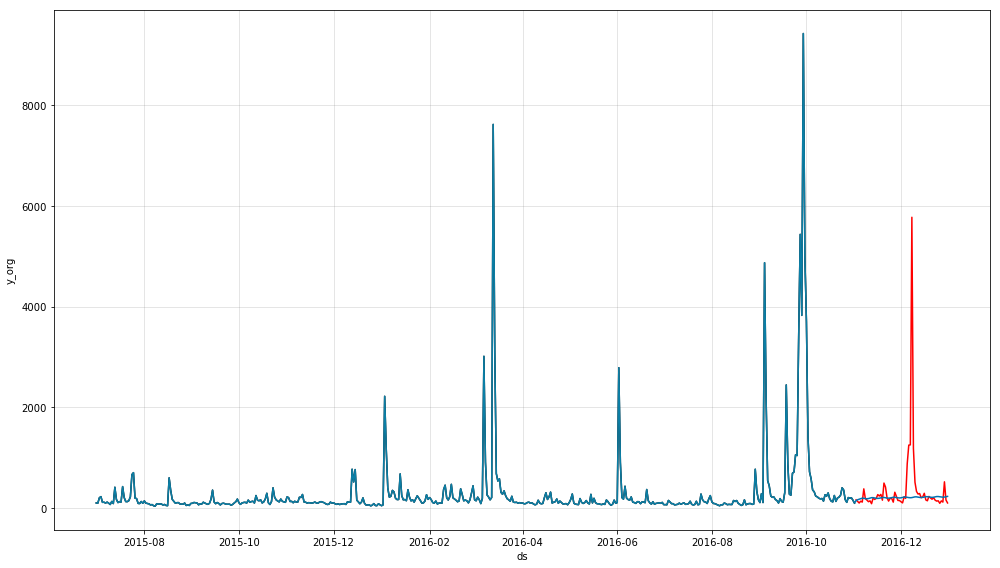

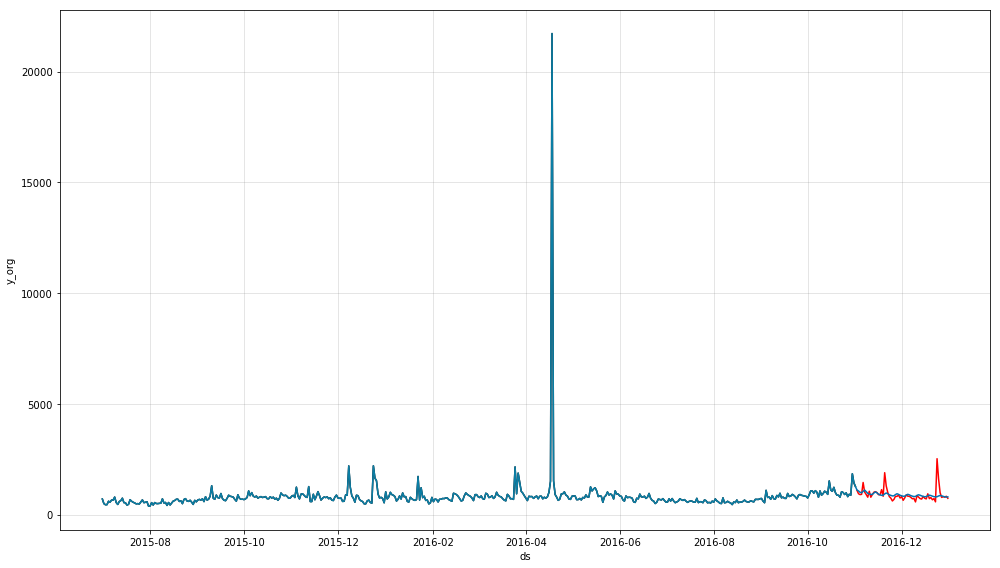

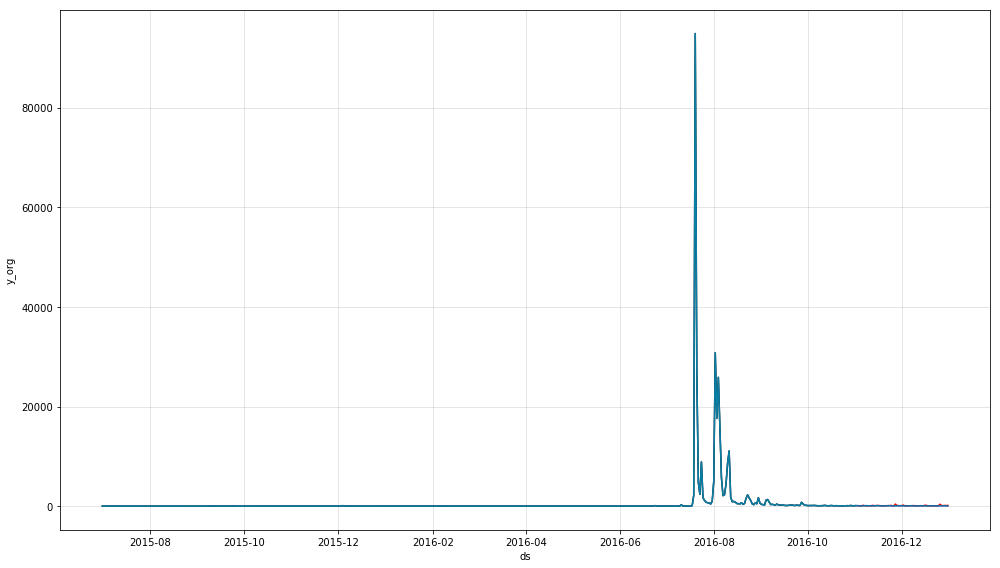

In [233]:
for x in range(140000,140010):
    newphet.prophet_plot(dataframes[x], uncertainty=False)